# 1. BTSP learning rule

In [1]:
# Imports 

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12,
                 'axes.spines.right': False,
                 'axes.spines.top': False,
                 'axes.linewidth':1.2,
                 'xtick.major.size': 6,
                 'xtick.major.width': 1.2,
                 'ytick.major.size': 6,
                 'ytick.major.width': 1.2,
                 'legend.frameon': False,
                 'legend.handletextpad': 0.1,
                 'figure.figsize': [10.0, 3.0],
                 'svg.fonttype': 'none',
                 'text.usetex': False})

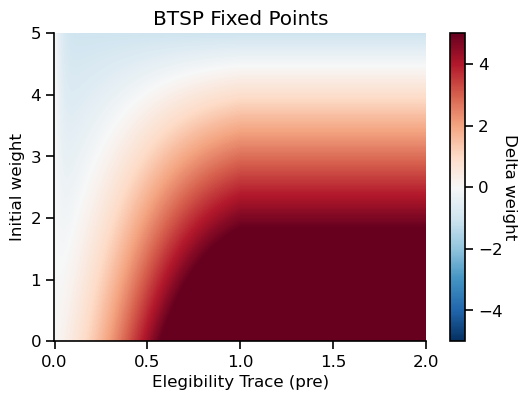

In [2]:
# Plot BTSP weight update function 

def get_scaled_rectified_sigmoid(th=0.01, peak=0.02, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    sigmoid_func = lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (np.clip(xi, x[0], x[-1]) - th))) - start_val) + ylim[0]
    return sigmoid_func

input_dim = 50
t_res = 0.01
tau_ET = 2.5
tau_IS = 1.5
sig_learning_rate = 1.7
sig_dep_ratio = 0.12
sig_max_weight = 5.
sig_dep_th = 0.01
sig_dep_width = 0.045
sig_pot_th = 0.5
sig_pot_width = 0.5
sig_dW_params = [sig_learning_rate, sig_dep_ratio, sig_max_weight]
sig_dep = get_scaled_rectified_sigmoid(sig_dep_th, sig_dep_th + sig_dep_width)
sig_pot = get_scaled_rectified_sigmoid(sig_pot_th, sig_pot_th + sig_pot_width)

def btsp(ET, IS, W, Wmax):
    k_pot = sig_learning_rate
    k_dep = sig_learning_rate * sig_dep_ratio
    dW = (Wmax - W) * k_pot * sig_pot(ET*IS) - W * k_dep * sig_dep(ET*IS)
    return dW

learning_rate = 1.
input_peak_rate = 2.0
max_weight_scale = 5.

pre = np.linspace(0., input_peak_rate, 1000)
w0 = np.linspace(0., max_weight_scale, 1000)
pre_mesh, w0_mesh = np.meshgrid(pre, w0)

plt.figure(figsize=[6,4])
plt.pcolormesh(pre_mesh, w0_mesh,
               btsp(pre_mesh, IS=1., W=w0_mesh, Wmax=max_weight_scale),
               cmap='RdBu_r', shading='nearest',
               vmin=-max_weight_scale * learning_rate, vmax=max_weight_scale * learning_rate)
plt.xlabel('Elegibility Trace (pre)')
plt.ylabel('Initial weight')
cbar = plt.colorbar()
cbar.set_label('Delta weight', rotation=-90., labelpad=10)
plt.title('BTSP Fixed Points')
plt.show()

# 2. BTSP simulation

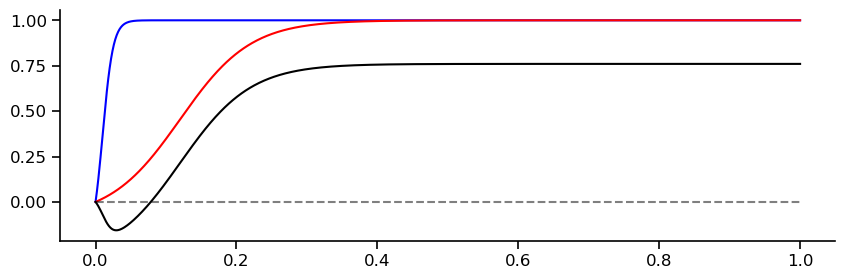

In [158]:
sig_dep_ratio = 0.12 *2
sig_learning_rate = 1.7

sig_dep_th = 0.01
sig_dep_width = 0.015
sig_pot_th = 0.12
sig_pot_width = 0.1
sig_dep = get_scaled_rectified_sigmoid(sig_dep_th, sig_dep_th + sig_dep_width)
sig_pot = get_scaled_rectified_sigmoid(sig_pot_th, sig_pot_th + sig_pot_width)

x = np.linspace(0,1,1000)
plt.plot(x,sig_dep(x),c='b')
plt.plot(x,sig_pot(x),c='r')
plt.plot(x,sig_pot(x)-sig_dep(x)*sig_dep_ratio,c='k')
plt.plot([0,1],[0,0],'k--',alpha=0.5)
plt.show()

In [159]:
# Run simulation of place cell with uniform equal weights

# Simulation runtime parameters
dt = 1.  # time step (ms)
T = 10000   # simulation time (ms)
time = np.arange(0., T, dt)

# def btsp(ET_IS, W, Wmax):
#     k_pot = sig_learning_rate
#     k_dep = sig_learning_rate * sig_dep_ratio
#     dW = (Wmax - W) * k_pot * sig_pot(ET_IS) - W * k_dep * sig_dep(ET_IS)
#     return dW

def btsp(ET, IS, W, Wmax):
    k_pot = sig_learning_rate
    k_dep = sig_learning_rate * sig_dep_ratio
    dW = (Wmax - W) * k_pot * sig_pot(ET*IS) - W * k_dep * sig_dep(ET*IS)
    return dW

def run_simulation(num_synapses, w_init, plateau_time):

    ET_tau = 2500 # (ms)
    IS_tau = 1500 # (ms)
    duration = 300
    Wmax = 5.

    plateau_time = np.round(plateau_time /dt) # (ms)
    first_stim_time = 100 # (ms)
    last_stim_time = T - first_stim_time
    stim_timesteps = np.linspace(first_stim_time, last_stim_time, num_synapses) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    
    # Initialize simulation variables
    simulation_results = {}
    weights = np.ones([len(time),num_synapses]) *w_init

    ET = np.zeros([len(time),num_synapses]) #presynaptic elegibility traces
    IS = np.zeros(len(time)) # postsynaptic instructive signal (plateau)
    
    for t in range(len(time)): 
        if t in stim_timesteps:
            active_synapse_ids = np.where(stim_timesteps==t)[0]
            ET[t,active_synapse_ids] += 0.3
            
        if t >= plateau_time and t < plateau_time + duration:
#             IS[t] = 1
            dISdt = (1 - IS[t])/ (IS_tau*0.03)
            IS[t] = IS[t] + dISdt*dt
            
        if t<len(time)-1: #don't update at the last timestep
            dETdt = -ET[t] / ET_tau
            ET[t+1] = ET[t] + dETdt*dt
            
            dISdt = -IS[t] / IS_tau
            IS[t+1] = IS[t] + dISdt*dt

            dW = btsp(ET[t], IS[t], weights[t], Wmax)
            weights[t+1] = weights[t] + dW*dt/1000

#     ET_IS = np.dot(IS,ET)  
#     ET_IS = ET_IS / np.max(ET_IS)
#     dW = btsp(ET_IS, weights, Wmax)
#     final_weights = weights + lr*dW
    
    simulation_results['el_traces'] = ET
    simulation_results['stim_times'] = stim_timesteps
    simulation_results['IS'] = IS
    simulation_results['W'] = weights
#     simulation_results['W'] = (weights, final_weights)

    return simulation_results
    
num_synapses = 30
init_weights = np.ones(num_synapses) * 1

weights = init_weights

simulation_results = run_simulation(num_synapses, weights, plateau_time=3000)
weights = simulation_results['W'][-1]

simulation_results2 = run_simulation(num_synapses, weights, plateau_time=7000)
weights = simulation_results2['W'][-1]

# for i in range(3):
#     simulation_results = run_simulation(num_synapses, weights, plateau_time=3000)
#     weights = simulation_results['W'][-1]
    
# for i in range(3):
#     simulation_results2 = run_simulation(num_synapses, weights, plateau_time=7000)
#     weights = simulation_results2['W'][-1]

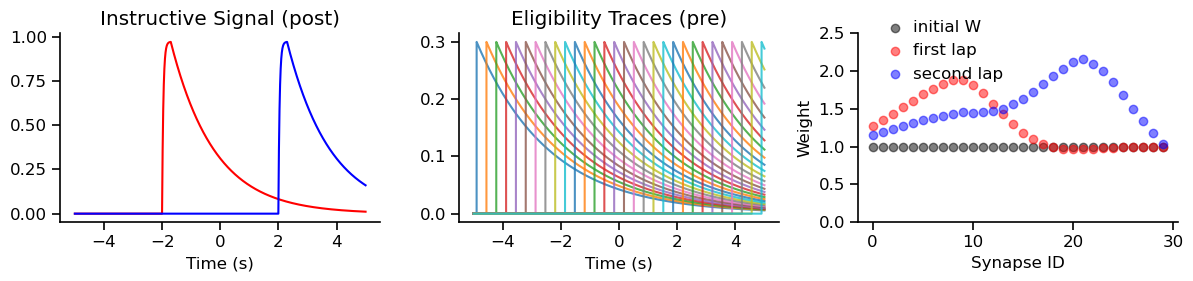

In [160]:
# Plot simulation results 

line_color = [0.2,0.2,0.2]
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 'el_traces':'Eligibility Traces (pre)',
         'IS': 'Instructive Signal (post)', 'W': 'Weight'}

time = np.arange(-T/2, T/2, dt)/1000

fig,ax = plt.subplots(1,3,figsize=(12,3))
plot_nr = (0)
ax[plot_nr].plot(time, simulation_results['IS'], c='r')
ax[plot_nr].plot(time, simulation_results2['IS'], c='b')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['IS'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results['el_traces'], alpha=0.8)
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['el_traces'])

plot_nr = (2)
ax[plot_nr].scatter(np.arange(num_synapses), init_weights, c='k', alpha=0.5, label='initial W')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][-1,:], c='r', alpha=0.5, label='first lap')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results2['W'][-1,:], c='b', alpha=0.5, label='second lap')

# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][0], c='k', alpha=0.5, label='initial W')
# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][1], c='r', alpha=0.5, label='first lap')
# ax[plot_nr].scatter(np.arange(num_synapses), simulation_results2['W'][1], c='b', alpha=0.5, label='second lap')
ax[plot_nr].set_xlabel('Synapse ID')
ax[plot_nr].set_ylabel(titles['W'])
ax[plot_nr].set_ylim([0,2.5])
ax[plot_nr].legend(loc='upper right', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
# plt.subplots_adjust(top=0.8)
plt.show()

# <font color='blue'> Emulating BTSP with neuromorphic hardware </font>

In [5]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt, temperature=70):
        self.dt = dt
        self.R = 5000+220
        self.R_history = []
        self.controlI = 0
        self.controlI_history = []
        self.temperature = temperature
        self.peak_R = self.R
        
    def time_step(self):
        self.R_history.append(self.R)
        self.controlI_history.append(self.controlI)

        R_eq = self.transfer_func(self.controlI)         

        if self.R > R_eq:
            self.peak_R = R_eq
            rise_tau = np.maximum(self.dt, self.rise_tau(R=self.R, temperature=self.temperature))
            dRdt = (R_eq - self.R) / rise_tau
        else:
            decay_tau = np.maximum(self.dt, self.decay_tau(R=self.peak_R, temperature=self.temperature))    
#             dRdt = (R_eq - self.R) / decay_tau
            dRdt = (R_eq - self.R)**0.95 / decay_tau
            
        self.R += dRdt * self.dt
        
    def transfer_func(self, controlI):
        '''
        Function to convert between controlI and resistance
        controlI: current in units of mA
        '''        
        R_eq = 5000*np.exp(-0.12*controlI)+220 # (Ohm)
        g_eq  = 1 / R_eq * 1e9 # convert to conductance (nS)
        return R_eq
    
    def inv_transfer_func(self, R):
        controlI = np.log((R-220)/5000)/(-0.12)
        return controlI
        
    def decay_tau(self, controlI=None, R=None, temperature=70):
        if controlI is None:
            controlI = self.inv_transfer_func(R)
#         tau = (0.44 * np.sqrt(controlI) + 1.45) * np.exp(0.2*(temperature-70))
#         tau = (0.029 * controlI + 3) * np.exp(0.2*(temperature-70))
#         tau = (0.018 * controlI**1.1 + 3) * np.exp(0.2*(temperature-70))
        tau = (0.018 * controlI**1.1 + 0.5) * np.exp(0.2*(temperature-70))
        tau = tau * 1e3 # convert to ms
        return tau 
    
    def rise_tau(self, R=None, temperature=70):
        tau = 1/(R+200) * np.exp(0.2*(temperature-72))
        tau = tau * 1e3 # convert to ms
        return tau
    
    @property
    def g(self):
        # Convert from resistance (Ohm) to conductance (nS)
        return 1e9/self.R


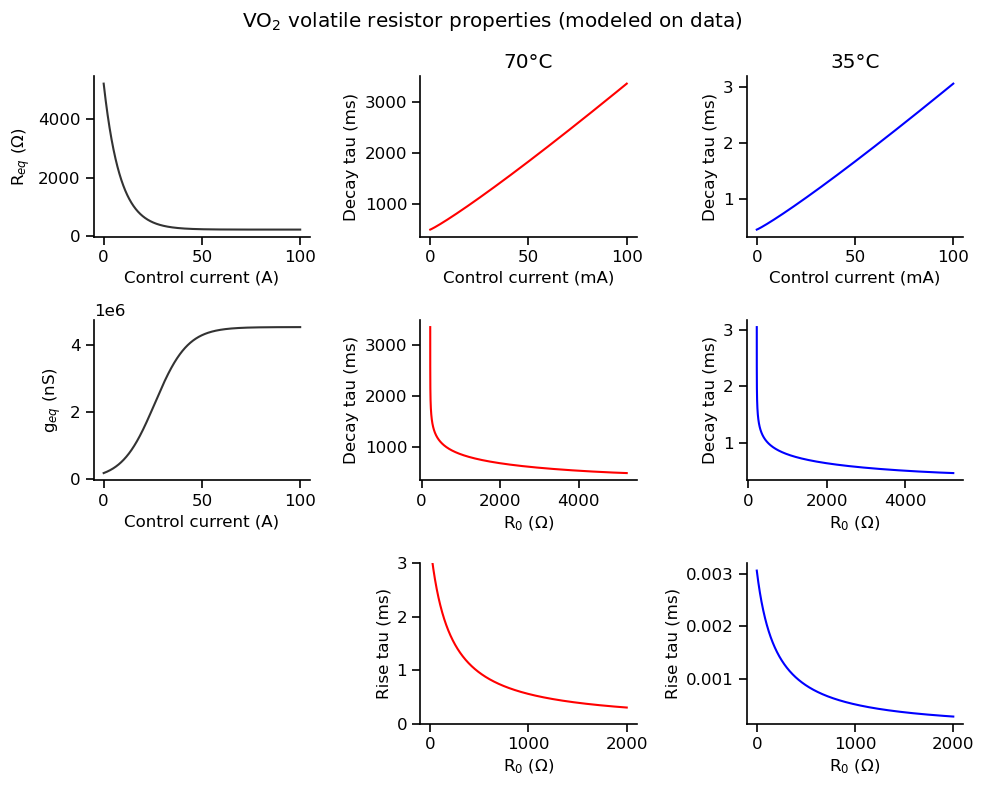

In [6]:
# Plot properties 

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

line_color = [0.2,0.2,0.2]
fig,ax = plt.subplots(3,3,figsize=[10,8])
g_volatile = Volatile_Resistor(dt)
controlI = np.linspace(0,100,1000)
R_eq = g_volatile.transfer_func(controlI)
g_eq = 1e9 / R_eq

ax[0,0].plot(controlI,R_eq, c=line_color)
ax[0,0].set_xlabel('Control current (A)')
ax[0,0].set_ylabel('R$_{eq}$ (Ω)')

ax[1,0].plot(controlI,g_eq, c=line_color)
ax[1,0].set_xlabel('Control current (A)')
ax[1,0].set_ylabel('g$_{eq}$ (nS)')

ax[0,1].plot(controlI,g_volatile.decay_tau(controlI=controlI,temperature=70),c='r',label='70°C')
ax[0,1].set_title('70°C')
ax[0,1].set_xlabel('Control current (mA)')
ax[0,1].set_ylabel('Decay tau (ms)')

ax[0,2].plot(controlI,g_volatile.decay_tau(controlI=controlI,temperature=35),c='b',label='30°C')
ax[0,2].set_title('35°C')
ax[0,2].set_xlabel('Control current (mA)')
ax[0,2].set_ylabel('Decay tau (ms)')

ax[1,1].plot(R_eq,g_volatile.decay_tau(R=R_eq,temperature=70),c='r')
ax[1,1].set_xlabel('R$_{0}$ (Ω)')
ax[1,1].set_ylabel('Decay tau (ms)')

ax[1,2].plot(R_eq,g_volatile.decay_tau(R=R_eq,temperature=35),c='b')
ax[1,2].set_xlabel('R$_{0}$ (Ω)')
ax[1,2].set_ylabel('Decay tau (ms)')

ax[2,0].axis('off')
R_range = np.linspace(0,2000,1000)
ax[2,1].plot(R_range,g_volatile.rise_tau(R=R_range,temperature=70),c='r')
ax[2,1].set_xlabel('R$_{0}$ (Ω)')
ax[2,1].set_ylabel('Rise tau (ms)')
ax[2,1].set_ylim([0,3])

R_range = np.linspace(0,2000,1000)
ax[2,2].plot(R_range,g_volatile.rise_tau(R=R_range,temperature=35),c='b')
ax[2,2].set_xlabel('R$_{0}$ (Ω)')
ax[2,2].set_ylabel('Rise tau (ms)')

plt.suptitle('VO$_{2}$ volatile resistor properties (modeled on data)')
plt.tight_layout()
plt.show()

In [7]:
# Run simulation of place cell with uniform equal weights

# Simulation runtime parameters
dt = 1  # time step (ms)
T = 10000   # simulation time (ms)
time = np.arange(0., T, dt)

def btsp(ET_IS, W, Wmax):
    k_pot = 1.5
    k_dep = 1.
    dW = (Wmax - W) * k_pot * sig_pot(ET_IS) - W * k_dep * sig_dep(ET_IS)
    return dW

# def btsp(ET, IS, W, Wmax):
#     k_pot = 1
#     k_dep = 0.1
#     dW = (Wmax - W) * k_pot * sig_pot(ET*IS) - W * k_dep * sig_dep(ET*IS)
#     return dW

def run_simulation(num_synapses, weights, plateau_time):

    ET_tau = 2500 # (ms)
    IS_tau = 1500 # (ms)
    duration = 1
    Wmax = 2.
    lr = 0.5

    plateau_time = np.round(plateau_time /dt) # (ms)
    first_stim_time = 100 # (ms)
    last_stim_time = T - first_stim_time
    stim_timesteps = np.linspace(first_stim_time, last_stim_time, num_synapses) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    
    # Initialize simulation variables
    simulation_results = {}

    # Initialize simulation variables
    synapse_list = []
    for i in range(num_synapses):
        synapse_list.append(Volatile_Resistor(dt, temperature=70))
    IS = Volatile_Resistor(dt, temperature=70)
        
    for t in range(len(time)): 
        
        if t in stim_timesteps: 
            # Increment synaptic el traces
            active_synapse_ids = np.where(stim_timesteps==t)[0]

            for i in active_synapse_ids:
                synapse.controlI = synapse.inv_transfer_func(synapse_list[i].g + 1.)

        if t >= plateau_time and t < plateau_time + duration:
            # Increment IS trace
            IS.g = IS.inv_transfer_func(IS.g + 1.)        
    
    ET = []
    for synapse in synapse_list:
        ET.append(synapse.R_history)
    ET = np.array(ET)
    IS = np.array(IS.R_history)
    
    
    
    
        
    ET_IS = np.dot(IS,ET)  
    ET_IS = ET_IS / np.max(ET_IS)
    dW = btsp(ET_IS, weights, Wmax)
    final_weights = weights + lr*dW
    
    simulation_results['el_traces'] = ET
    simulation_results['stim_times'] = stim_timesteps
    simulation_results['IS'] = IS
    simulation_results['W'] = (weights, final_weights)

    return simulation_results
    
num_synapses = 30
weights = np.ones(num_synapses) *0.5
simulation_results = run_simulation(num_synapses, weights, plateau_time=3000)

weights2 = simulation_results['W'][1]
simulation_results2 = run_simulation(num_synapses, weights2, plateau_time=7000)


UnboundLocalError: local variable 'synapse' referenced before assignment

In [ ]:
# Plot simulation results 

line_color = [0.2,0.2,0.2]
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 'el_traces':'Eligibility Traces (pre)',
         'IS': 'Instructive Signal (post)', 'W': 'Weight'}

time = np.arange(-T/2, T/2, dt)/1000

fig,ax = plt.subplots(1,3,figsize=(12,3))
plot_nr = (0)
ax[plot_nr].plot(time, simulation_results['IS'], c='r')
ax[plot_nr].plot(time, simulation_results2['IS'], c='b')
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['IS'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results['el_traces'], alpha=0.8)
ax[plot_nr].set_xlabel('Time (s)')
ax[plot_nr].set_title(titles['el_traces'])

plot_nr = (2)
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][0], c='k', alpha=0.5, label='initial W')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results['W'][1], c='r', alpha=0.5, label='first lap')
ax[plot_nr].scatter(np.arange(num_synapses), simulation_results2['W'][1], c='b', alpha=0.5, label='second lap')
ax[plot_nr].set_xlabel('Synapse ID')
ax[plot_nr].set_ylabel(titles['W'])
ax[plot_nr].set_ylim([0,2])
ax[plot_nr].legend(loc='upper right', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
# plt.subplots_adjust(top=0.8)
plt.show()

In [10]:
# Run simulation of place cell with uniform equal weights

# Simulation runtime parameters
dt = 1.  # time step (ms)
T = 6000   # simulation time (ms)
time = np.arange(0., T, dt)

def btsp(ET, IS, W, Wmax):
    k_dep = 0.3
    dW = (Wmax - W)*ET*IS - k_dep*W*sigmoid(ET * IS)
    return dW

def run_simulation(num_synapses, w, plateau_time=3000):
    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 200 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    V_cell = 0
    V_probe = 70
    syn_tau = 5 # (ms)
    ET_tau = 30  # (ms)
    IS_tau = 50  # (ms)
    Wmax = 2.
    lr = 0.003

    baselineV = 0.1
    AMPA_synapse = Volatile_Resistor(dt)
    baselineV_syn = AMPA_synapse.compute_controlV(syn_tau)
    baselineV_ET = AMPA_synapse.compute_controlV(ET_tau)
    baselineV_IS = AMPA_synapse.compute_controlV(IS_tau)
    controlV_dur = 10

    plateau_time = np.round(plateau_time /dt) # (ms)
    first_stim_time = 100 # (ms)
    last_stim_time = T - first_stim_time

    stim_timesteps = np.linspace(first_stim_time, last_stim_time, num_synapses) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    stim_timesteps_extended = np.repeat(stim_timesteps,controlV_dur) + np.tile(np.arange(controlV_dur),len(stim_timesteps))
    
    # Initialize simulation variables
    synapse_list = []
    for i in range(num_synapses):
        synapse_list.append(Synapse(dt))
    IS = Volatile_Resistor(dt)

    simulation_results = {}
    weights = np.ones([len(time),num_synapses]) * w
    V = np.ones(len(time)) * V_cell
    I = np.zeros([len(time),num_synapses])
    
    for t in range(len(time)): 
        if t not in stim_timesteps_extended:
            for i in range(num_synapses):
#                 if t > stim_timesteps[i]: # if synapse has been activated
                synapse_list[i].ET.controlV = baselineV_ET
                synapse_list[i].channel.controlV = baselineV_syn
        IS.controlV = baselineV_IS

        if t in stim_timesteps:
            active_synapse_ids = np.where(stim_timesteps==t)[0]

            for i in active_synapse_ids:
                synapse = synapse_list[i]
                synapse.ET.controlV = synapse.inv_transfer_func(synapse.ET.g + 1.)
                if i==30:
                    print(weights[t,i],synapse.channel.g)
                    
                synapse.channel.controlV = synapse.inv_transfer_func(synapse.channel.g + weights[t,i])

        if t >= plateau_time and t < plateau_time + controlV_dur:
            IS.g = IS.inv_transfer_func(IS.g + 1.)

        for i in range(num_synapses):
            I[t,i] = synapse_list[i].channel.g * V_probe *1e-3
        
        I_total = np.sum(I[t])
            
        if t<len(time)-1: #don't update at the last timestep
            dVdt = ((V_cell-V[t]) + I_total*R) * (1/cell_tau) 
            V[t+1] = V[t] + dVdt*dt

            ET = np.array([synapse_list[i].ET.g for i in range(num_synapses)])
            dW = btsp(ET, IS.g, weights[t], Wmax)
            weights[t+1] = weights[t] + lr*dW


        for i in range(num_synapses):
            synapse_list[i].time_step()
        IS.time_step()



    control_v = []
    ET = []
    for i in range(num_synapses):
        control_v.append(synapse_list[i].channel.controlV_history)
        ET.append(synapse_list[i].ET.g_history)

    simulation_results['control_v'] = np.array(control_v).T
    simulation_results['V'] = V
    simulation_results['I'] = I
    simulation_results['el_traces'] = np.array(ET).T
    simulation_results['stim_times'] = stim_timesteps
    simulation_results['IS'] = IS.g_history
    simulation_results['W'] = weights

    return simulation_results
    
num_synapses = 40
weights = np.ones(num_synapses) * 0.5
simulation_results = run_simulation(num_synapses, weights)

new_weights = simulation_results['W'][-1]
simulation_results2 = run_simulation(num_synapses, new_weights)

AttributeError: 'Volatile_Resistor' object has no attribute 'compute_controlV'